In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
#from helper_functions.scan_helper_functions import AdjustedRSquared
#from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated

In [2]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [3]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [4]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [6]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [8]:
import shutil

In [10]:
directory1 = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model1/forward_id/train_forward_model_53442_00000_0_2022-09-20_15-37-09/surrogate_model'

directory2 = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model1/model'
shutil.copytree(directory1, directory2)

'/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model1/model'

In [11]:
#directory = '/data/project/general/aerosolretriev'
#test_datafile = directory +'/aerosol_data/raw_data/pre_log_ts-0.2_P11_wl-532/test_dataset.hdf5'
directory = directory2
#test_datafile = directory +'/aerosol_data/dataset_15_08_2022/data/data_test_trunc_fw.h5'

test_datafile= '/data/project/general/aerosolretriev/aerosol_data/dataset_08_10_2022/data_all_test_fw.h5'
#test_datafile = directory +'/aerosol_data/raw_data/pre_log_ts-0.2_P11_wl-532_sc-None_switched/test_dataset.hdf5'

In [12]:
#model_name = 'forward_model'
model_name = 'forward_model'

In [13]:
#model_dir = directory +'/aerosol_results_august_2022/forward_model/version2_trunc/models'
#model_dir = directory +'/aerosol_results_25_08_2022/forward_model/models/forward_model'


#model_dir = directory +'/aerosol_results_25_08_2022/forward_model/models/forward_model'
#model_dir ='/data/project/general/aerosolretriev/aerosol_results_25_08_2022/best_model'

#model_dir = '/data/project/general/aerosolretriev/aerosol_results_ds08/aerosol_results_11_09_2022/forward_model2/models'
#model_dir = '/data/project/general/aerosolretriev/aerosol_results_ds08/aerosol_results_11_09_2022/forward_model2/models/forward_model'

In [14]:
model_dir =  directory2

In [15]:
#plot_dir = f'../plots/models/{model_name}'
plot_dir = model_dir +'/plots/model'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [16]:
test_datafile

'/data/project/general/aerosolretriev/aerosol_data/dataset_08_10_2022/data_all_test_fw.h5'

In [17]:
model_dir

'/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model1/model'

In [18]:
model_name

'forward_model'

# Load the model and the data

In [22]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

#surr = KerasSurrogate.load(model_dir, model_name, model_kwargs=kwargs)
#import tensorflow as tf
#tf.keras.backend.set_floatx('float32')

#surr = KerasSurrogate.load(model_dir, model_name)
surr = KerasSurrogate.load('/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model1','model', model_kwargs=kwargs)

In [23]:
from tensorflow import keras
#surr = keras.models.load_model('/data/project/general/aerosolretriev/aerosol_results_25_08_2022/forward_model2/models/forward_model')



#surr = keras.models.load_model('/data/project/general/aerosolretriev/aerosol_results_25_08_2022/best_model/')


#surr = keras.models.load_model(model_dir)


In [24]:
dir(surr)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_surrogate',
 '_fit_model',
 '_load_model',
 '_model',
 '_name',
 '_predict_model',
 '_save_model',
 '_version',
 'details',
 'fit',
 'load',
 'model',
 'name',
 'predict',
 'preprocessor_x',
 'preprocessor_y',
 'save',
 'version']

In [25]:
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')

In [26]:
dvar_test.describe()

F11_10        F11_11        F11_12        F11_13        F11_14  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       4.745280      4.598268      4.458331      4.325928      4.200499   
std        2.665670      2.692795      2.719803      2.744343      2.767103   
min       -3.038451     -3.000078     -3.677873     -3.941128     -3.619981   
25%        2.601702      2.461499      2.314533      2.187715      2.070506   
50%        4.735658      4.589805      4.453887      4.323017      4.199870   
75%        6.920807      6.780902      6.644190      6.514823      6.389499   
max       10.596831     10.573233     10.547368     10.519230     10.488816   

             F11_15        F11_16        F11_17        F11_18        F11_19  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       4.080411      3.965383      3.855518      3.750109      3.649078   
std        2.788244      2.807845      2.826382      2.844244      2.860974   
min       -3.683784     -3.822893     -4.210827     -4.113702     -4.228093   
25%        1.946160      1.831749      1.728889      1.621111      1.522161   
50%        4.081967      3.966829      3.857322      3.753065      3.648350   
75%        6.276201      6.166499      6.062248      5.966131      5.877313   
max       10.456121     10.421140     10.383871     10.344309     10.302454   

       ...       PPF_161       PPF_162       PPF_163       PPF_164  \
count  ...  20000.000000  20000.000000  20000.000000  20000.000000   
mean   ...      0.312857      0.286775      0.261489      0.236999   
std    ...      0.363829      0.344956      0.326273      0.307643   
min    ...     -8.530286     -8.626041     -8.537174     -8.262138   
25%    ...      0.205644      0.187375      0.169919      0.153069   
50%    ...      0.319231      0.293991      0.269070      0.244487   
75%    ...      0.447606      0.407954      0.369054      0.331114   
max    ...      7.629647      7.729583      7.591701      7.234237   

            PPF_165       PPF_166       PPF_167       PPF_168       PPF_169  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.213308      0.190461      0.168524      0.147572      0.127655   
std        0.288618      0.268876      0.248449      0.227574      0.206521   
min       -7.814557     -7.221561     -6.519704     -5.749684     -4.951292   
25%        0.136878      0.121330      0.106705      0.092784      0.079624   
50%        0.221121      0.197652      0.174871      0.152675      0.131389   
75%        0.294306      0.259358      0.226274      0.194791      0.165379   
max        7.597947      7.821004      7.687750      7.229026      6.515664   

            PPF_170  
count  20000.000000  
mean       0.108785  
std        0.185483  
min       -4.159618  
25%        0.067346  
50%        0.111064  
75%        0.138125  
max        5.643329  

[8 rows x 300 columns]

dvar = pd.read_hdf(datafile, key='dvar')
qoi = pd.read_hdf(datafile, key='qoi')

n_in = dvar.shape[1]

dvar_trainval, dvar_test, qoi_trainval, qoi_test = train_test_split(dvar,
                                                                    qoi,
                                                                    test_size=0.2)
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

dvar_trainval.reset_index(drop=True, inplace=True)
qoi_trainval.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=5, random_state=76, shuffle=True)

train_ind, val_ind = next(kf.split(dvar_trainval))

dvar_train = dvar_trainval.values[train_ind]
dvar_val = dvar_trainval.values[val_ind]
qoi_train = qoi_trainval.values[train_ind]
qoi_val = qoi_trainval.values[val_ind]

In [27]:
#surr.evaluate(dvar_test,qoi_test)

In [28]:
dvar_test

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      3.520372  3.370919  3.223337  3.078055  2.935392  2.795585  2.658810   
1      2.993383  2.906044  2.816038  2.723926  2.630191  2.535254  2.439479   
2      2.083922  1.867308  1.665001  1.475370  1.297082  1.129031  0.970285   
3      4.631656  4.608993  4.584164  4.557170  4.528009  4.496681  4.463187   
4      5.166876  5.061900  4.958952  4.858128  4.759479  4.663025  4.568766   
...         ...       ...       ...       ...       ...       ...       ...   
19995  8.967994  8.912232  8.855130  8.796952  8.737918  8.678210  8.617980   
19996  2.485260  2.468145  2.449422  2.429098  2.407180  2.383675  2.358593   
19997  3.508680  3.401139  3.294218  3.188264  3.083539  2.980245  2.878532   
19998  8.758696  8.629973  8.506614  8.388176  8.274274  8.164572  8.058773   
19999  5.462620  5.418097  5.373526  5.329017  5.284647  5.240477  5.196556   

         F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0      2.525198  2.394844  2.267817  ...  0.254317  0.234739  0.215524   
1      2.343187  2.246660  2.150146  ...  0.329730  0.304415  0.279175   
2      0.820055  0.677661  0.542517  ...  0.185951  0.170201  0.155019   
3      4.427529  4.389708  4.349729  ...  0.334489  0.336085  0.330612   
4      4.476688  4.386768  4.298978  ...  0.343605  0.317005  0.290598   
...         ...       ...       ...  ...       ...       ...       ...   
19995  8.557358  8.496452  8.435355  ...  0.617443  0.558342  0.501723   
19996  2.331944  2.303737  2.273986  ...  0.584512  0.531100  0.479272   
19997  2.778518  2.680291  2.583919  ...  0.302530  0.280880  0.259105   
19998  7.956617  7.857872  7.762334  ...  0.337305  0.307412  0.278373   
19999  5.152917  5.109587  5.066588  ...  0.497445  0.448755  0.402257   

        PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0      0.196658  0.178139  0.159982  0.142222  0.124915  0.108140  0.091999  
1      0.254103  0.229309  0.204921  0.181082  0.157949  0.135694  0.114496  
2      0.140412  0.126372  0.112874  0.099897  0.087451  0.075565  0.064272  
3      0.318982  0.302154  0.281106  0.256819  0.230245  0.202302  0.173850  
4      0.264469  0.238714  0.213443  0.188782  0.164871  0.141864  0.119927  
...         ...       ...       ...       ...       ...       ...       ...  
19995  0.447661  0.396236  0.347532  0.301635  0.258635  0.218624  0.181694  
19996  0.429224  0.381146  0.335224  0.291636  0.250552  0.212133  0.176530  
19997  0.237273  0.215468  0.193796  0.172380  0.151363  0.130907  0.111193  
19998  0.250265  0.223168  0.197166  0.172346  0.148799  0.126620  0.105906  
19999  0.358013  0.316084  0.276530  0.239409  0.204777  0.172687  0.143192  

[20000 rows x 300 columns]

In [29]:
dvar_test.columns

Index(['F11_10', 'F11_11', 'F11_12', 'F11_13', 'F11_14', 'F11_15', 'F11_16',
       'F11_17', 'F11_18', 'F11_19',
       ...
       'PPF_161', 'PPF_162', 'PPF_163', 'PPF_164', 'PPF_165', 'PPF_166',
       'PPF_167', 'PPF_168', 'PPF_169', 'PPF_170'],
      dtype='object', length=300)

# Predict

In [30]:
# first scale the input data


def scaling(df,df_min,df_max,scale_min,scale_max):
    df_std = (df-df_min) / (df_max-df_min)
    df_scaled = df_std* (scale_max - scale_min)+scale_min
    return df_scaled

def scaling_reverse(df,df_min,df_max,scale_min,scale_max):
    df_scaled_reverse = (df-scale_min)/(scale_max-scale_min)*(df_max-df_min)+df_min
    return df_scaled_reverse

scale_min = 0
scale_max = 1

In [31]:
#minmax_datafile = '/data/project/general/aerosolretriev/aerosol_results_25_08_2022/forward_model2/minmax_dvar_fw.h5'
#minmax_datafile = '/data/project/general/aerosolretriev/aerosol_results_ds08/aerosol_results_11_09_2022/forward_model2/minmax_dvar_fw.h5'
#df_min = pd.read_hdf(minmax_datafile,key = 'min')
#df_max = pd.read_hdf(minmax_datafile,key = 'max')

#print(df_min)
#print(df_max)

In [32]:
dvar_test

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      3.520372  3.370919  3.223337  3.078055  2.935392  2.795585  2.658810   
1      2.993383  2.906044  2.816038  2.723926  2.630191  2.535254  2.439479   
2      2.083922  1.867308  1.665001  1.475370  1.297082  1.129031  0.970285   
3      4.631656  4.608993  4.584164  4.557170  4.528009  4.496681  4.463187   
4      5.166876  5.061900  4.958952  4.858128  4.759479  4.663025  4.568766   
...         ...       ...       ...       ...       ...       ...       ...   
19995  8.967994  8.912232  8.855130  8.796952  8.737918  8.678210  8.617980   
19996  2.485260  2.468145  2.449422  2.429098  2.407180  2.383675  2.358593   
19997  3.508680  3.401139  3.294218  3.188264  3.083539  2.980245  2.878532   
19998  8.758696  8.629973  8.506614  8.388176  8.274274  8.164572  8.058773   
19999  5.462620  5.418097  5.373526  5.329017  5.284647  5.240477  5.196556   

         F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0      2.525198  2.394844  2.267817  ...  0.254317  0.234739  0.215524   
1      2.343187  2.246660  2.150146  ...  0.329730  0.304415  0.279175   
2      0.820055  0.677661  0.542517  ...  0.185951  0.170201  0.155019   
3      4.427529  4.389708  4.349729  ...  0.334489  0.336085  0.330612   
4      4.476688  4.386768  4.298978  ...  0.343605  0.317005  0.290598   
...         ...       ...       ...  ...       ...       ...       ...   
19995  8.557358  8.496452  8.435355  ...  0.617443  0.558342  0.501723   
19996  2.331944  2.303737  2.273986  ...  0.584512  0.531100  0.479272   
19997  2.778518  2.680291  2.583919  ...  0.302530  0.280880  0.259105   
19998  7.956617  7.857872  7.762334  ...  0.337305  0.307412  0.278373   
19999  5.152917  5.109587  5.066588  ...  0.497445  0.448755  0.402257   

        PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0      0.196658  0.178139  0.159982  0.142222  0.124915  0.108140  0.091999  
1      0.254103  0.229309  0.204921  0.181082  0.157949  0.135694  0.114496  
2      0.140412  0.126372  0.112874  0.099897  0.087451  0.075565  0.064272  
3      0.318982  0.302154  0.281106  0.256819  0.230245  0.202302  0.173850  
4      0.264469  0.238714  0.213443  0.188782  0.164871  0.141864  0.119927  
...         ...       ...       ...       ...       ...       ...       ...  
19995  0.447661  0.396236  0.347532  0.301635  0.258635  0.218624  0.181694  
19996  0.429224  0.381146  0.335224  0.291636  0.250552  0.212133  0.176530  
19997  0.237273  0.215468  0.193796  0.172380  0.151363  0.130907  0.111193  
19998  0.250265  0.223168  0.197166  0.172346  0.148799  0.126620  0.105906  
19999  0.358013  0.316084  0.276530  0.239409  0.204777  0.172687  0.143192  

[20000 rows x 300 columns]

In [23]:
dvar_test_scaled = scaling(dvar_test,df_min,df_max,scale_min,scale_max)
dvar_test_scaled

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      0.485356  0.473043  0.464339  0.480773  0.471258  0.448328  0.462958   
1      0.449221  0.440658  0.435676  0.456793  0.450568  0.430213  0.448330   
2      0.386860  0.368297  0.354672  0.372244  0.360195  0.332361  0.350347   
3      0.561556  0.559290  0.560107  0.580935  0.579223  0.566700  0.583295   
4      0.598255  0.590841  0.586483  0.601315  0.594914  0.578275  0.590336   
...         ...       ...       ...       ...       ...       ...       ...   
17995  0.858894  0.859066  0.860676  0.868043  0.864617  0.857673  0.860386   
17996  0.414379  0.410153  0.409875  0.436828  0.435449  0.419665  0.442936   
17997  0.484554  0.475148  0.469328  0.488236  0.481301  0.461178  0.477611   
17998  0.844543  0.839403  0.836149  0.840361  0.833186  0.821931  0.823092   
17999  0.618534  0.615655  0.615658  0.633203  0.630516  0.618457  0.632205   

         F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0      0.456012  0.438088  0.445960  ...  0.478939  0.455271  0.452380   
1      0.443898  0.428043  0.438201  ...  0.483096  0.459290  0.456180   
2      0.342522  0.321692  0.332197  ...  0.475170  0.451549  0.448768   
3      0.582625  0.573305  0.583237  ...  0.483358  0.461116  0.459250   
4      0.585897  0.573106  0.579891  ...  0.483861  0.460016  0.456861   
...         ...       ...       ...  ...       ...       ...       ...   
17995  0.857495  0.851672  0.852635  ...  0.498956  0.473934  0.469465   
17996  0.443149  0.431912  0.446367  ...  0.497141  0.472363  0.468125   
17997  0.472872  0.457436  0.466803  ...  0.481596  0.457932  0.454981   
17998  0.817511  0.808387  0.808257  ...  0.483513  0.459462  0.456132   
17999  0.630905  0.622101  0.630505  ...  0.492341  0.467614  0.463527   

        PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0      0.482318  0.513027  0.530241  0.537735  0.550654  0.550786  0.498351  
1      0.485749  0.516152  0.533052  0.540143  0.552666  0.552495  0.499726  
2      0.478958  0.509866  0.527294  0.535113  0.548372  0.548765  0.496656  
3      0.489624  0.520600  0.537818  0.544835  0.557069  0.556628  0.503353  
4      0.486368  0.516726  0.533585  0.540620  0.553087  0.552878  0.500058  
...         ...       ...       ...       ...       ...       ...       ...  
17995  0.497310  0.526345  0.541973  0.547612  0.558797  0.557640  0.503833  
17996  0.496209  0.525424  0.541203  0.546992  0.558305  0.557238  0.503517  
17997  0.484744  0.515307  0.532356  0.539604  0.552264  0.552199  0.499524  
17998  0.485520  0.515777  0.532567  0.539602  0.552108  0.551933  0.499201  
17999  0.491956  0.521451  0.537532  0.543757  0.555517  0.554790  0.501480  

[18000 rows x 300 columns]

In [24]:
qoi_pred_scaled = surr.predict(dvar_test_scaled)
qoi_pred_scaled = pd.DataFrame(data=qoi_pred_scaled, columns=qoi_test.columns)

In [25]:
qoi_pred_scaled.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean       0.113561      0.235118      0.496194      0.501018      0.501638
std        0.207583      0.256461      0.285815      0.290291      0.287105
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.036874      0.249654      0.249974      0.251715
50%        0.013286      0.126569      0.494780      0.499351      0.503767
75%        0.111332      0.360242      0.745986      0.751861      0.750357
max        1.394503      1.012586      1.003644      1.222476      1.012552

In [26]:
qoi_test.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean     576.121312   1253.031261      1.996431      2.159699      1.103524
std     1047.387832   1267.232900      0.574952      0.483124      0.632293
min        1.000783    100.008814      1.001019      1.330003      0.000135
25%        8.000351    265.658897      1.501265      1.741477      0.554082
50%       67.106629    717.583799      1.992211      2.157726      1.105678
75%      578.605879   1874.496470      2.498469      2.574063      1.649918
max     4998.395477   4999.474451      2.999704      2.999911      2.199874

In [27]:
#rescale the predictions

#minmax_datafile_qoi = '/data/project/general/aerosolretriev/aerosol_results_25_08_2022/forward_model2/minmax_qoi_fw.h5'
minmax_datafile_qoi = '/data/project/general/aerosolretriev/aerosol_results_ds08/aerosol_results_11_09_2022/forward_model2/minmax_qoi_fw.h5'
df_min_qoi = pd.read_hdf(minmax_datafile_qoi,key = 'min')
df_max_qoi = pd.read_hdf(minmax_datafile_qoi,key = 'max')

print(df_min_qoi)
print(df_max_qoi)





Vtot          1.000002
RmedianV    100.001602
GSD           1.001031
n             1.330022
k             0.000023
dtype: float64
Vtot        4999.850738
RmedianV    4999.930437
GSD            2.999991
n              2.999993
k              2.199981
dtype: float64


In [28]:
qoi_pred = scaling_reverse(qoi_pred_scaled,df_min_qoi,df_max_qoi,scale_min,scale_max)



In [166]:
qoi_pred.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean     568.674059   1252.062843      1.992903      2.166707      1.103606
std     1037.675210   1256.642028      0.571332      0.484778      0.631619
min        1.000002    100.001602      1.001031      1.330022      0.000023
25%        1.000002    280.683787      1.500080      1.747472      0.553786
50%       67.414364    720.179929      1.990076      2.163924      1.108290
75%      557.533736   1865.163642      2.492226      2.585607      1.650776
max     6971.911841   5061.602514      3.007274      3.371523      2.227595

In [30]:
qoi_test.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean     576.121312   1253.031261      1.996431      2.159699      1.103524
std     1047.387832   1267.232900      0.574952      0.483124      0.632293
min        1.000783    100.008814      1.001019      1.330003      0.000135
25%        8.000351    265.658897      1.501265      1.741477      0.554082
50%       67.106629    717.583799      1.992211      2.157726      1.105678
75%      578.605879   1874.496470      2.498469      2.574063      1.649918
max     4998.395477   4999.474451      2.999704      2.999911      2.199874

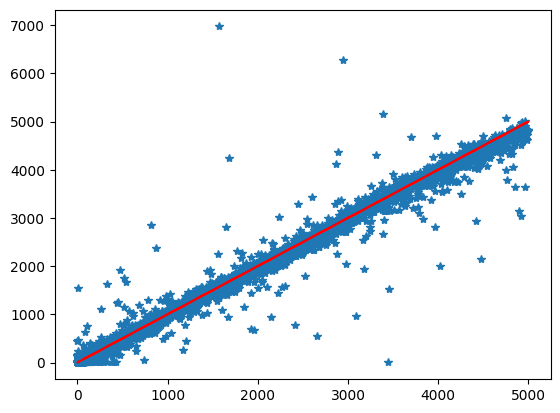

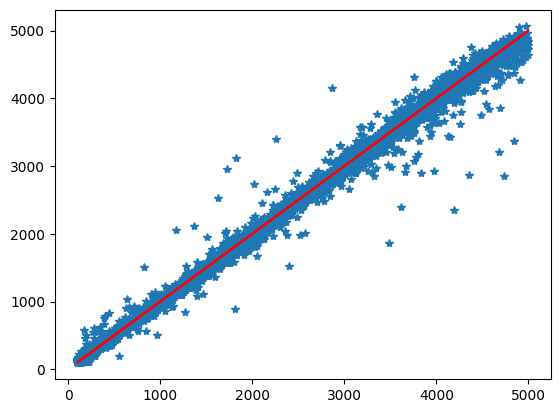

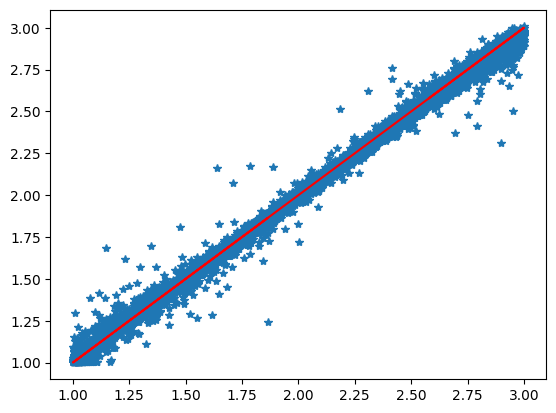

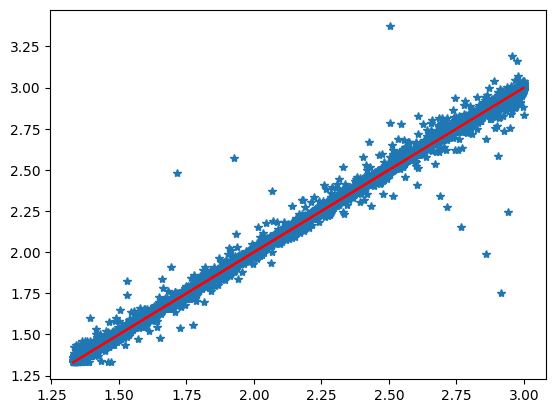

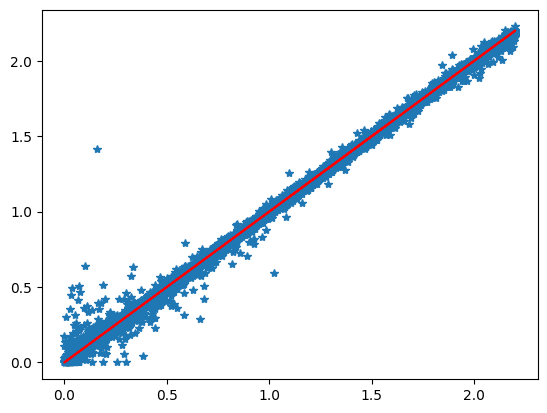

In [31]:

for col in qoi_pred.keys():
    plt.figure()
    plt.plot(qoi_test[col],qoi_pred[col],"*")
    plt.plot(qoi_test[col],qoi_test[col],'r')

In [32]:
# Mean absolute error
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

In [33]:
for col in qoi_pred.keys():
    MAE = mean_absolute_error(qoi_test[col],qoi_pred[col])
    col_mean = qoi_test[col].mean()
    col_p = MAE / col_mean *100
    print(col,'***',MAE,'***', col_mean,'***',col_p)

Vtot *** 34.215653986588386 *** 576.1213120610701 *** 5.938966892959074
RmedianV *** 32.11225991507712 *** 1253.0312610012975 *** 2.562766062948518
GSD *** 0.016578657165437487 *** 1.9964306278191026 *** 0.8304148881720966
n *** 0.012571409534292796 *** 2.159699124170475 *** 0.5820907826279452
k *** 0.012293490321655855 *** 1.1035239278693876 *** 1.114021183518089


In [34]:
for col in qoi_pred.keys():
    RMSE = np.sqrt(mean_squared_error(qoi_test[col],qoi_pred[col]))
    col_mean = qoi_test[col].mean()
    col_p = MAE / col_mean *100
    print(col,'***',MAE,'***', col_mean,'***',col_p)

Vtot *** 0.012293490321655855 *** 576.1213120610701 *** 0.0021338371041466904
RmedianV *** 0.012293490321655855 *** 1253.0312610012975 *** 0.000981100049477786
GSD *** 0.012293490321655855 *** 1.9964306278191026 *** 0.61577347844464
n *** 0.012293490321655855 *** 2.159699124170475 *** 0.5692223599144949
k *** 0.012293490321655855 *** 1.1035239278693876 *** 1.114021183518089


In [35]:
for col in qoi_pred.keys():
    EVS = explained_variance_score(qoi_test[col],qoi_pred[col])
    print(col, EVS)

Vtot 0.9897387577441805
RmedianV 0.9969638308631406
GSD 0.9975355601911042
n 0.9974287817452021
k 0.9985408291883694


# Calculate metrics

In [36]:
qoi_test.columns.values

array(['Vtot', 'RmedianV', 'GSD', 'n', 'k'], dtype=object)

In [37]:
res = qoi_test - qoi_pred

q = np.arange(0.1, 1.0, 0.05)
q = np.append(q, [0.98, 0.99])
q = np.round(q, decimals=3)
quantiles = res.abs().quantile(q)
quantiles.to_csv(f'{plot_dir}/forward_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

In [38]:
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj = pd.Series(data=r2_adj, index=qoi_test.columns)
r2_adj = np.round(r2_adj, decimals=2)
r2_adj = pd.DataFrame(r2_adj).T

In [39]:
r2_adj = pd.DataFrame(r2_adj)

In [40]:
r2_adj

Vtot  RmedianV  GSD    n    k
0  0.99       1.0  1.0  1.0  1.0

In [41]:
min(r2_adj.min())

0.99

In [42]:
qoi_test.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean     576.121312   1253.031261      1.996431      2.159699      1.103524
std     1047.387832   1267.232900      0.574952      0.483124      0.632293
min        1.000783    100.008814      1.001019      1.330003      0.000135
25%        8.000351    265.658897      1.501265      1.741477      0.554082
50%       67.106629    717.583799      1.992211      2.157726      1.105678
75%      578.605879   1874.496470      2.498469      2.574063      1.649918
max     4998.395477   4999.474451      2.999704      2.999911      2.199874

In [43]:
qoi_pred.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean     568.674059   1252.062843      1.992903      2.166707      1.103606
std     1037.675210   1256.642028      0.571332      0.484778      0.631619
min        1.000002    100.001602      1.001031      1.330022      0.000023
25%        1.000002    280.683787      1.500080      1.747472      0.553786
50%       67.414364    720.179929      1.990076      2.163924      1.108290
75%      557.533736   1865.163642      2.492226      2.585607      1.650776
max     6971.911841   5061.602514      3.007274      3.371523      2.227595

In [44]:
qoi_test = qoi_test.reset_index(drop = True)
qoi_test

Vtot     RmedianV       GSD         n         k
0         9.782479   740.955994  1.860629  1.509454  1.576845
1         4.953045   447.099789  1.687354  2.622790  0.754203
2         9.853527  2953.110936  2.635387  2.087974  1.787399
3        27.700011   254.587570  1.044152  2.913697  1.101197
4        49.011526   519.446422  2.185569  2.364048  2.055679
...            ...          ...       ...       ...       ...
17995  2902.889066   244.818462  2.048755  1.459021  0.468698
17996     3.793219   204.348275  1.206468  1.562014  1.081841
17997     8.990683   528.078164  1.949690  2.689447  1.873984
17998  2367.063858   780.091790  2.555797  2.806807  0.538075
17999    84.401659   168.632644  2.579873  2.563342  1.104086

[18000 rows x 5 columns]

In [45]:
error = qoi_pred - qoi_test
error

Vtot   RmedianV       GSD         n         k
0       -8.782478   2.455371 -0.007334  0.004661  0.009750
1       -3.953043  -4.532512 -0.008509  0.000198 -0.016830
2       -8.853525 -46.998948 -0.007123  0.009155  0.006657
3      -26.700009  17.312396 -0.032664 -0.032451  0.040131
4       -0.514421   1.338542 -0.021883  0.009300  0.004826
...           ...        ...       ...       ...       ...
17995  -25.388376   8.321593  0.004555 -0.002272  0.001787
17996   -2.793217  11.054360 -0.007311 -0.019051 -0.008315
17997   -7.990681   4.545384  0.002584  0.015796  0.022676
17998 -154.253273 -43.198389 -0.042303  0.018677 -0.001391
17999    4.809289  22.345277  0.009261  0.009577  0.002360

[18000 rows x 5 columns]

In [46]:
abs_error = np.abs(qoi_test-qoi_pred)
abs_error = pd.DataFrame(abs_error, columns=qoi_test.columns).abs()
abs_error.reset_index(drop=True, inplace=True)
abs_error

Vtot   RmedianV       GSD         n         k
0        8.782478   2.455371  0.007334  0.004661  0.009750
1        3.953043   4.532512  0.008509  0.000198  0.016830
2        8.853525  46.998948  0.007123  0.009155  0.006657
3       26.700009  17.312396  0.032664  0.032451  0.040131
4        0.514421   1.338542  0.021883  0.009300  0.004826
...           ...        ...       ...       ...       ...
17995   25.388376   8.321593  0.004555  0.002272  0.001787
17996    2.793217  11.054360  0.007311  0.019051  0.008315
17997    7.990681   4.545384  0.002584  0.015796  0.022676
17998  154.253273  43.198389  0.042303  0.018677  0.001391
17999    4.809289  22.345277  0.009261  0.009577  0.002360

[18000 rows x 5 columns]

In [49]:
abs_error[qoi_test['Vtot']>2000].sort_values('Vtot',ascending = False)

Vtot    RmedianV       GSD         n         k
16888  3437.459364  279.772573  0.018226  0.648020  0.069002
14867  3333.854573  384.432580  0.000423  0.098911  0.040993
16265  2320.578355   75.472959  0.070775  0.347980  0.216042
15687  2130.063506  373.925118  0.021682  0.087652  0.137158
5640   2114.227399  140.864312  0.272229  0.022296  0.010822
...            ...         ...       ...       ...       ...
5502      0.268729   43.743508  0.025811  0.000672  0.016738
8372      0.166694   10.966884  0.007072  0.017298  0.025873
3473      0.147527   29.456854  0.015490  0.003780  0.009374
14036     0.130774    2.162689  0.013605  0.001817  0.002888
10988     0.027221   13.421240  0.003010  0.010270  0.005078

[1900 rows x 5 columns]

In [50]:
abs_error.mean()

Vtot        34.215654
RmedianV    32.112260
GSD          0.016579
n            0.012571
k            0.012293
dtype: float64

In [51]:
abs_error_table = np.round(abs_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table

Vtot  RmedianV   GSD     n     k
50%   14.35     17.33  0.01  0.01  0.01
75%   35.41     34.25  0.02  0.02  0.01
90%   73.02     68.97  0.03  0.02  0.02
95%  113.02    105.81  0.05  0.03  0.03
99%  288.09    237.94  0.10  0.07  0.07

In [52]:
rel_error = np.abs(qoi_test - qoi_pred) / qoi_test * 100.
rel_error = pd.DataFrame(rel_error, columns=qoi_test.columns).abs()
rel_error.reset_index(drop=True, inplace=True)
rel_error

Vtot   RmedianV       GSD         n         k
0      89.777627   0.331379  0.394148  0.308795  0.618339
1      79.810367   1.013758  0.504274  0.007534  2.231442
2      89.851334   1.591506  0.270291  0.438467  0.372461
3      96.389888   6.800173  3.128239  1.113733  3.644302
4       1.049592   0.257686  1.001238  0.393397  0.234788
...          ...        ...       ...       ...       ...
17995   0.874590   3.399087  0.222316  0.155725  0.381202
17996  73.637124   5.409569  0.605948  1.219652  0.768572
17997  88.877357   0.860741  0.132543  0.587348  1.210065
17998   6.516650   5.537603  1.655193  0.665407  0.258433
17999   5.698098  13.250861  0.358986  0.373601  0.213768

[18000 rows x 5 columns]

In [105]:
rel_error.mean()

Vtot        46.409312
RmedianV     4.555652
GSD          0.919195
n            0.595629
k           14.302483
dtype: float64

In [54]:
rel_error_table = np.round(rel_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table

Vtot  RmedianV   GSD     n      k
50%  23.48      2.40  0.55  0.43   0.80
75%  78.20      5.30  1.10  0.72   1.91
90%  93.46     10.98  1.93  1.13   5.51
95%  96.11     16.06  2.80  1.52  13.27
99%  98.74     30.86  6.43  3.30  99.84

In [55]:
rel_indexV = rel_error.sort_values('Vtot', ascending = False).head(100).index

In [56]:
rel_indexV

Int64Index([  210,  9606, 12879,   808,   751,  5489, 15628,  3853,   119,
             9580,   572, 16195,  1426, 13911, 15817, 12877, 12956,  7892,
             1083, 13382,  3558,  5424,   779,    85,  9499, 14478, 15936,
             3969,  3452,  3991,  1258,  1006, 12738,  8772, 12711, 13409,
            17782, 16024,  2977,  7592, 17171,  1506, 12431,  7644, 13066,
             5470, 12390,  3153, 16169,  1667,  8908, 14228,  2181,  7092,
             5801,  5015,  6212,  6370,  4401, 13364, 17922, 17869,  2978,
            10708,  3697, 10094,  3698,    23, 17300,  4846,  3420,  3027,
              884, 12114,  5262,  5301, 10645,  2227,  7715,  5007,  2088,
            13543,  2732, 16009,  1796, 10857,  4006, 14596, 15429,  9092,
             8234, 12530,  7565, 12374,  7176,   289,  5151,   388,  1149,
            17446],
           dtype='int64')

In [57]:
qoi_test.loc[rel_indexV].sort_values('Vtot')

Vtot     RmedianV       GSD         n         k
808       1.202681   293.583383  1.025392  1.431556  0.375392
9606      1.290011   280.296663  1.037820  2.808774  0.033948
751       1.740063  2743.400656  1.640479  1.459967  0.004201
16195     2.075413   160.014084  1.012489  2.323325  1.421981
12879     2.372320   285.204478  1.075334  2.404350  0.008915
...            ...          ...       ...       ...       ...
5015    534.497544   170.742634  1.030629  2.035332  0.119217
5470    821.798800   142.755773  1.061114  2.769397  0.123178
3420    872.495940  3612.239073  1.001830  2.860847  2.006062
3969   1575.665513   253.993038  1.001019  1.428218  1.624365
2227   1679.924245  3522.455509  1.002386  2.953391  0.589561

[100 rows x 5 columns]

In [59]:
qoi_pred_index = qoi_pred[np.round(qoi_pred['Vtot'], decimals =0 )==1].index

In [60]:
qoi_test.loc[qoi_pred_index].sort_values('Vtot')

Vtot     RmedianV       GSD         n         k
1271      1.000783  1208.154383  1.278861  2.762786  0.471459
14910     1.001519  1691.520953  2.723089  1.404531  0.906635
9009      1.001766  3275.438460  1.230161  1.702773  1.470394
4933      1.002143   306.495876  1.515497  2.839982  1.978343
11415     1.002369   214.660365  1.954383  2.608118  0.158691
...            ...          ...       ...       ...       ...
11140   324.575274  1167.264940  1.116627  2.167404  0.003232
1284    381.280088   159.380524  1.079649  1.601417  0.046659
316     405.611637   846.265805  1.854480  1.494797  0.043845
1468    433.442714   800.921913  1.639439  1.472714  0.059639
16888  3438.459365   347.794807  1.019257  1.925971  0.069024

[7427 rows x 5 columns]

In [61]:
rel_error[qoi_test['Vtot']>2000].sort_values('Vtot',ascending = False)

Vtot   RmedianV        GSD          n          k
14867  113.283533   7.791814   0.042265   3.644483   2.163359
16888   99.970917  80.441849   1.788161  33.646419  99.967315
5640    79.611337   7.389324  20.977293   1.648725  99.791973
15687   68.944312  96.283148   2.120015   6.570882  69.587696
8069    67.540080  10.457912   2.106541   2.701343   5.444014
...           ...        ...        ...        ...        ...
5502     0.011635   1.549751   1.175275   0.035027   0.832784
14036    0.006277   0.403125   0.627975   0.115512   0.158781
3473     0.004736  15.064062   0.827248   0.161542   2.060440
8372     0.003419   1.141613   0.502342   0.631280   3.115452
10988    0.001157   9.377464   0.102508   0.446025   0.482388

[1900 rows x 5 columns]

In [64]:
rel_error[qoi_test['Vtot']<200].mean()

Vtot        70.175316
RmedianV     4.406727
GSD          0.898475
n            0.576992
k           19.224771
dtype: float64

In [65]:
rel_error[qoi_test['Vtot']>200].mean()

Vtot        6.742921
RmedianV    4.804212
GSD         0.953779
n           0.626735
k           6.086990
dtype: float64

In [135]:
rel_error_Vtot = rel_error.sort_values('Vtot', ascending = False).head(2000).index

In [154]:
qoi_test1 = qoi_test[qoi_test['Vtot']>300].copy()
qoi_pred1 = qoi_pred[qoi_test['Vtot']>300].copy()

#qoi_test1 = qoi_test.drop(rel_error_Vtot, axis = 0).copy()
#qoi_pred1 =qoi_pred.drop(rel_error_Vtot,axis = 0).copy()

In [155]:
qoi_test1 = qoi_test1.reset_index(drop = True)
qoi_pred1 = qoi_pred1.reset_index(drop=True)

In [156]:
abs_error1 = np.abs(qoi_test1-qoi_pred1)
abs_error1 = pd.DataFrame(abs_error1, columns=qoi_test1.columns).abs()
abs_error1.reset_index(drop=True, inplace=True)
abs_error1.mean()

Vtot        72.433118
RmedianV    35.212628
GSD          0.017469
n            0.013303
k            0.012824
dtype: float64

In [157]:
rel_error1 = np.abs(qoi_test1 - qoi_pred1) / qoi_test1 * 100.
rel_error1 = pd.DataFrame(rel_error1, columns=qoi_test1.columns).abs()
rel_error1.reset_index(drop=True, inplace=True)
rel_error1

Vtot  RmedianV       GSD         n         k
0     6.342708  2.142782  0.109575  0.484662  0.105483
1     2.755919  1.508906  3.264373  0.518645  0.180561
2     5.682113  3.499056  0.188632  0.941316  0.604160
3     4.964472  3.791349  0.585650  0.306400  0.526262
4     4.828828  4.188884  0.723055  0.752846  1.082566
...        ...       ...       ...       ...       ...
5853  2.818558  0.919950  0.845162  0.139653  0.370870
5854  0.443459  0.189372  0.688375  0.499155  0.557092
5855  1.014018  0.802390  0.981523  1.110328  0.530666
5856  0.874590  3.399087  0.222316  0.155725  0.381202
5857  6.516650  5.537603  1.655193  0.665407  0.258433

[5858 rows x 5 columns]

In [158]:
rel_error_table1 = np.round(rel_error1.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [160]:
rel_error_table1

Vtot  RmedianV   GSD     n      k
50%   3.21      2.59  0.59  0.44   0.83
75%   6.31      5.61  1.17  0.76   1.97
90%  11.35     11.40  2.01  1.16   5.82
95%  17.41     17.53  2.88  1.60  14.83
99%  43.19     31.44  6.62  3.83  99.91

In [161]:
#wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [162]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
np.round(wMAPE_qoi, decimals =2)

Vtot  RmedianV   GSD     n     k
0  5.94      2.56  0.83  0.58  1.11

In [163]:
wMAPE_qoi1 = wmape(qoi_test1, qoi_pred1)
wMAPE_qoi1 = pd.DataFrame(wMAPE_qoi1).T
np.round(wMAPE_qoi1, decimals =2)

Vtot  RmedianV   GSD     n     k
0  4.36      2.83  0.87  0.62  1.18

In [108]:
qoi_pred.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean     568.674059   1252.062843      1.992903      2.166707      1.103606
std     1037.675210   1256.642028      0.571332      0.484778      0.631619
min        1.000002    100.001602      1.001031      1.330022      0.000023
25%        1.000002    280.683787      1.500080      1.747472      0.553786
50%       67.414364    720.179929      1.990076      2.163924      1.108290
75%      557.533736   1865.163642      2.492226      2.585607      1.650776
max     6971.911841   5061.602514      3.007274      3.371523      2.227595

In [167]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [168]:
qoi_test

Vtot     RmedianV       GSD         n         k
0         9.782479   740.955994  1.860629  1.509454  1.576845
1         4.953045   447.099789  1.687354  2.622790  0.754203
2         9.853527  2953.110936  2.635387  2.087974  1.787399
3        27.700011   254.587570  1.044152  2.913697  1.101197
4        49.011526   519.446422  2.185569  2.364048  2.055679
...            ...          ...       ...       ...       ...
17995  2902.889066   244.818462  2.048755  1.459021  0.468698
17996     3.793219   204.348275  1.206468  1.562014  1.081841
17997     8.990683   528.078164  1.949690  2.689447  1.873984
17998  2367.063858   780.091790  2.555797  2.806807  0.538075
17999    84.401659   168.632644  2.579873  2.563342  1.104086

[18000 rows x 5 columns]

In [169]:
qoi_test['DmedianV']=qoi_test['RmedianV']*2*1e-3 #[um]
qoi_test['DmedianN']=(np.exp(np.log(qoi_test['DmedianV']) - (3*np.log(qoi_test['GSD'])**2))) *1e3   #[nm]
qoi_test['Ntot'] = 6 / np.pi * qoi_test['Vtot']*1e9 / (np.exp((3*np.log(qoi_test['DmedianN'])) + (4.5*np.log(qoi_test['GSD'])**2))) # [cm^-3]
 

In [170]:
qoi_pred['DmedianV']=qoi_pred['RmedianV']*2*1e-3 #[um]
qoi_pred['DmedianN']=(np.exp(np.log(qoi_pred['DmedianV']) - (3*np.log(qoi_pred['GSD'])**2))) *1e3 #[nm] 
qoi_pred['Ntot'] = 6 / np.pi * qoi_pred['Vtot']*1e9 / (np.exp((3*np.log(qoi_pred['DmedianN'])) + (4.5*np.log(qoi_pred['GSD'])**2))) # [cm^-3]


In [171]:
D_array = np.logspace(1, 4.5, 200)  # [nm]


In [178]:
presentation_plot_index = [1000,2000,3000,4000,5000]

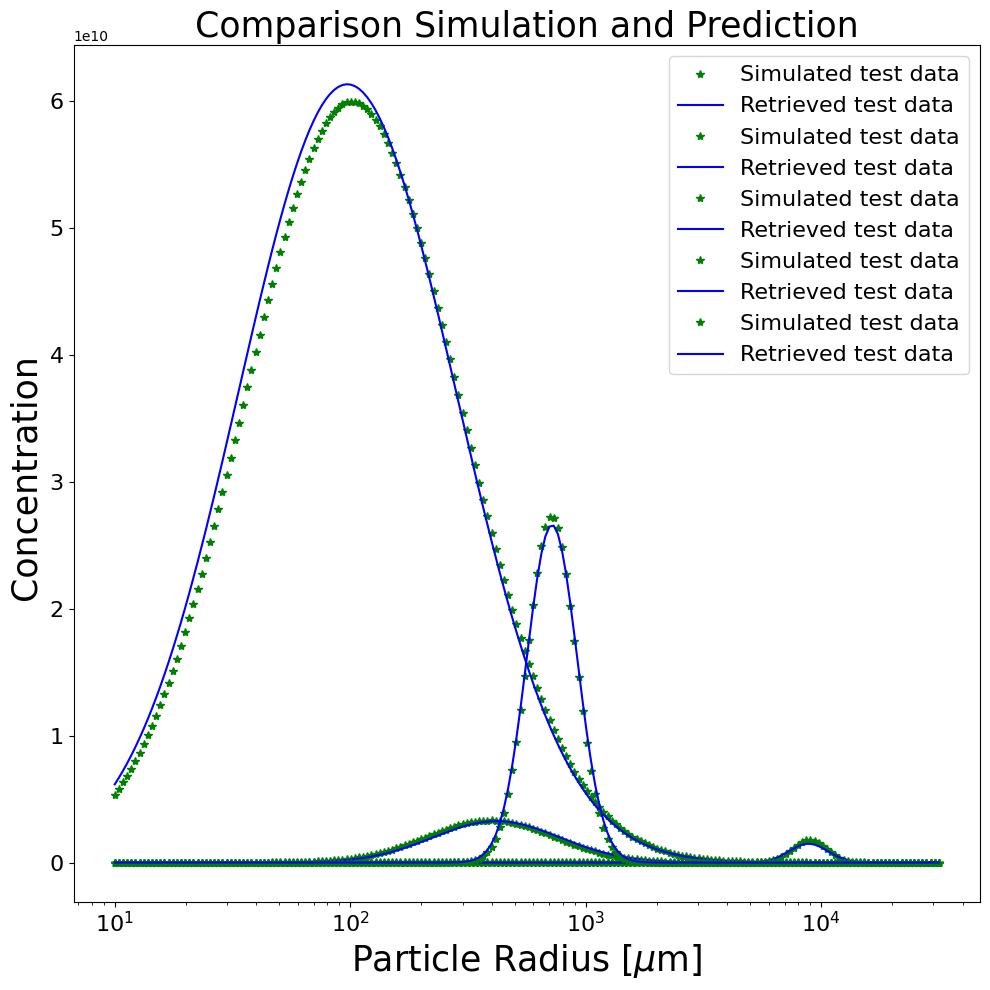

In [176]:
fig, ax = plt.subplots(figsize = (10,10))



for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, qoi_test['DmedianN'].loc[i], qoi_test['GSD'].loc[i], qoi_test['Ntot'].loc[i])
    pdf2 = lognormal(D_array, qoi_pred['DmedianN'].loc[i], qoi_pred['GSD'].loc[i], qoi_pred['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*g', label = 'Simulated test data')
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., 'b', label = 'Retrieved test data')
    

    
ax.legend(['Predicted test data', 'test data'], fontsize = 16)
ax.legend(fontsize = 16)   

ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/GSD_GMR_iv.jpg')

In [ ]:
## Test testcases

In [ ]:
datafile = '/data/project/general/aerosolretriev/aerosol_data/bimodal_to_monomodal_16_08_2022/datasetbmtomm_qoi.h5'
qoi_test_1 = pd.read_hdf(datafile,key='qoi1')
qoi_test_2 = pd.read_hdf(datafile,key='qoi2')
qoi_test_cases = pd.read_hdf(datafile,key='qoi')
dvar_test_1 = pd.read_hdf(datafile,key='dvar1')
dvar_test_2 = pd.read_hdf(datafile,key='dvar2')

In [ ]:
qoi_test_cases = qoi_test_cases.drop(['F11_5','F11_6','F11_7','F11_8','F11_9','F11_171','F11_172','F11_173','F11_174','F11_175'], axis =1)

In [ ]:
qoi_test_cases = qoi_test_cases.drop(['PPF_5','PPF_6','PPF_7','PPF_8','PPF_9','PPF_171','PPF_172','PPF_173','PPF_174','PPF_175'], axis =1)


In [ ]:
F11_list = [x for x in qoi_test_cases.columns if 'F11'in x]
PPF_list = [x for x in qoi_test_cases.columns if 'PPF'in x]


In [ ]:
qoi_test_cases[F11_list]=np.log(qoi_test_cases[F11_list])

In [ ]:
dvar_test_cases_scaled = scaling(qoi_test_cases,df_min,df_max,scale_min,scale_max)
dvar_test_cases_scaled

In [ ]:
dvar_test_cases_scaled.columns

In [ ]:
qoi_pred_cases_scaled = surr.predict(dvar_test_cases_scaled)
qoi_pred_cases_scaled = pd.DataFrame(data=qoi_pred_cases_scaled, columns=dvar_test_1.columns)

In [ ]:
qoi_pred_cases_scaled

In [ ]:
qoi_pred_cases = scaling_reverse(qoi_pred_cases_scaled,df_min_qoi,df_max_qoi,scale_min,scale_max)



In [ ]:
qoi_pred_cases

In [ ]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [ ]:
# Computing size distributions for dvar1 and dvar2
D_array = np.logspace(1.0177287669604316, 4.556302500767287, 1000)

for index in dvar_test_1.index:
    V_tot, R_median_V, GSD, ri_n, ri_k = dvar_test_1.loc[index].values

    D_median_V = R_median_V*2  # [nm]
#    print(D_median_V)
    D_median_N = (np.exp(np.log(D_median_V) - (3*np.log(GSD)**2)))      # [nm]
#    print(D_median_N)
  
    N_tot = 6 / np.pi * V_tot*1e9 / (np.exp((3*np.log(D_median_N)) + (4.5*np.log(GSD)**2))) # [cm^-3]

    ndvar_1 = lognormal(D_array, D_median_N , GSD, N_tot) *D_array    
    
    
    V_tot, R_median_V, GSD, ri_n, ri_k = dvar_test_2.loc[index].values

    D_median_V = R_median_V*2  # [nm]
#    print(D_median_V)
    D_median_N = (np.exp(np.log(D_median_V) - (3*np.log(GSD)**2)))      # [nm]
#    print(D_median_N)
  
    N_tot = 6 / np.pi * V_tot*1e9 / (np.exp((3*np.log(D_median_N)) + (4.5*np.log(GSD)**2))) # [cm^-3]

    ndvar_2 = lognormal(D_array, D_median_N , GSD, N_tot) *D_array
    
    V_tot, R_median_V, GSD, ri_n, ri_k = qoi_pred_cases.loc[index].values

    D_median_V = R_median_V*2  # [nm]
#    print(D_median_V)
    D_median_N = (np.exp(np.log(D_median_V) - (3*np.log(GSD)**2)))      # [nm]
#    print(D_median_N)
  
    N_tot = 6 / np.pi * V_tot*1e9 / (np.exp((3*np.log(D_median_N)) + (4.5*np.log(GSD)**2))) # [cm^-3]

    ndvar_pred= lognormal(D_array, D_median_N , GSD, N_tot) *D_array
    
    fs = 15
    fig,ax=plt.subplots(1,1,figsize =(10,6))
    ax.plot(D_array,ndvar_1*4/3*np.pi*(D_array/2.)**3.+ndvar_2*4/3*np.pi*(D_array/2.)**3. ,'b.',label = 'bimodal')
    ax.plot(D_array,ndvar_pred*4/3*np.pi*(D_array/2.)**3.,'k',label = 'predicted')
    ax.set_xscale('log')
    ax.legend(fontsize = fs)
    ax.set_xlabel('Radius')
    ax.set_ylabel('volume size distribution dV/dlogD')
    ax.set_title('test case'+str(index))
#plt.title('$V_{tot}=$ %.1f$\mu m^3 cm^{-3}$, $D=$ %.2f$\mu m$, GSD=%.4f \n m= %.4f -i %.5f' %
#             (parameters1['Vtot'].loc[index], parameters1['RmedianV'].iloc[index]*2*1e-3,
#              parameters1['GSD'].loc[index], parameters1['n'].iloc[index], parameters1['k'].iloc[index]))

# Save $\bar{R}^2$

In [ ]:
#r2_adj.to_latex(f'{plot_dir}/r2_table.tex', index=False, escape=False)

In [ ]:
r2_adj_T = r2_adj.T
r2_adj_T=r2_adj_T.rename(columns={0: "r2_adj"})
r2_adj_T

# Plot

In [ ]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(pd.DataFrame(r2_adj_T, columns = ['r2_adj']).T,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/forward_model_r2_adj.jpg')


## Relative Errors

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/isodar_forward_rel_error_percentiles.jpg')

## DVARs vs. percentage errors

In [ ]:
def plot_error_vs_dvar(design_var):
    fig, axes = plt.subplots(4, 3, figsize=(16, 27))


    for i, col in enumerate(qoi_test.columns[0:12]):
        ax = axes.flatten()[i]

        ax.plot(dvar_test[design_var],
                rel_error[col],
                'o');

        ax.hlines(y=0.,
                  xmin=dvar_test[design_var].min(),
                  xmax=dvar_test[design_var].max(),
                  color='red',
                  zorder=3)

        ax.set_xlabel(design_var, fontsize=20)
        ax.set_ylabel(r'$\Delta$' + col + r' [%]', fontsize=20)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        

    fig.tight_layout()
    fig.savefig(f'{plot_dir}/percentage_error_vs_{design_var}.jpg')
    
    return fig

In [ ]:
qoi_test.columns[0:11]

In [ ]:
qoi_pred[qoi_pred['Vtot']<0]

In [ ]:
for d in dvar_test.columns:
    plot_error_vs_dvar(d)

## Correlations between DVARs and QOIs

In [ ]:
combined = pd.concat([dvar_test, rel_error], axis=1)

In [ ]:
corr = np.round(combined.corr(), decimals=2)

In [ ]:
to_plot = corr.copy()
to_plot.drop(columns=dvar_test.columns, inplace=True)
#to_plot.rename(columns=qoi.columns, index=qoi.columns.values, inplace=True)

In [ ]:
qoi_test.columns

In [ ]:
to_plot = to_plot.drop(qoi_test.columns, axis =0)

In [ ]:
to_plot

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            cmap='coolwarm',
            linewidths=0.01,
           # annot=True,
            ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', length=0, labelsize=10)

fig.tight_layout()
fig.savefig(f'{plot_dir}/rel_error_correlations.jpg')

## Residuals

In [ ]:
error


In [ ]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi_test.columns[0:3]:
    sns.distplot(error[col], ax=ax)
ax.text(x=-0.025,
        y=5,
        color=colors[0],
        s=r'$phase_0.0$',
        fontsize=30)
ax.text(x=0.015,
        y=3,
        color=colors[1],
        s=r'$phase_1.0$',
        fontsize=30)
ax.text(x=0.01,
        y=4,
        color=colors[2],
        s=r'$phase_2.0$',
        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi.columns:
    sns.distplot(error[col], ax=ax)
#ax.text(x=-0.025,
#        y=15,
#        color=colors[0],
#        s=r'$\sigma_x$',
#        fontsize=30)
#ax.text(x=0.015,
#        y=30,
#        color=colors[1],
#        s=r'$\sigma_y$',
#        fontsize=30)
#ax.text(x=0.01,
#        y=40,
#        color=colors[2],
#        s=r'$\sigma_z$',
#        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

In [ ]:
def standardise(x):
    return (x - x.mean()) / x.std()

In [ ]:
for i, col in enumerate(qoi_test.columns[0:11]):
    print(i)
    print(col)

In [ ]:
fig, axes= plt.subplots(4, 3, figsize=(16, 9))

for i, col in enumerate(qoi_test.columns[0:12]):
    ax = axes.flatten()[i]
    scipy.stats.probplot(standardise(error[col]), dist="norm", plot=ax);
#    ax.set_title(qoi.columns[col], fontsize=20)
    ax.set_ylabel('Quantiles of\n standardised residuals')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    ax.grid(True, which='minor')
    #ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

fig.tight_layout()
fig.savefig(f'{plot_dir}/residual_normality_plots.jpg')

In [ ]:
# pd.DataFrame({'Mean': error.mean(axis=0), 'std': error.std(axis=0)})

In [ ]:
rel_error.abs().quantile(0.9)

In [ ]:
qoi_columns = qoi_test.columns

In [ ]:
statistic, p = scipy.stats.shapiro(standardise(error[qoi_test.columns[0]]).values)

In [ ]:
statistic

In [ ]:
p

In [ ]:
surr.model.summary()

In [ ]:
qoi_pred

In [ ]:
test_index = qoi_test.index.tolist()
test_index

In [ ]:
presentation_plot_index = [0,1,3,4,5,6]

qoi_test.index.values

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in qoi_test.index.values:
    ax.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    ax.plot(np.arange(3,len(qoi_pred.columns)+3),qoi_pred.iloc[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data__result_all.jpg')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    plot_test_data = ax.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = ax.plot(np.arange(3,len(qoi_pred.columns)+3),qoi_pred.iloc[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
ax.legend(['Test data', 'Predicted test data'], fontsize = 16)
#ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data__result.jpg')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in qoi_test.index.values:
    ax.plot(qoi_test.iloc[index],qoi_pred.iloc[index],'b*')
    
    #plt.yscale('logit')
    
    
ax.set_xlabel('Test data',fontsize = 25)
ax.set_ylabel('Predicted test data ',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 

ax.axline([-25, -25], [-8, -8])


#fig.align_labels()
#ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data_correlation.jpg')

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_dir

In [ ]:
plot_model(surr.model, show_shapes=True,show_layer_names=True, to_file = f'{plot_dir}/model_architecture.png')


In [ ]:
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(pd.DataFrame(r2_adj_T, columns = ['r2_adj']).T,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            linewidths = 0.01,
            cmap='coolwarm',)
plt.tick_params(labelsize = 16)
plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred.columns)+3),qoi_pred.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_forward_model.jpg')
